In [1]:
import numpy as np 
import pandas as pd 
import random

In [2]:
import seaborn as sns 
import matplotlib.pyplot as plt 

plt.style.use('ggplot')
%matplotlib inline

In [3]:
df_feature = pd.read_csv('../input/raw/tox21_dense_train.csv')
df_target = pd.read_csv('../input/raw/tox21_labels_train.csv')

In [4]:
df_feature_test = pd.read_csv('../input/raw/tox21_dense_test.csv')
df_target_test = pd.read_csv('../input/raw/tox21_labels_test.csv')

### Target analysis

In [5]:
df_target.head()

,Unnamed: 0,NR.AhR,NR.AR,NR.AR.LBD,NR.Aromatase,NR.ER,NR.ER.LBD,NR.PPAR.gamma,SR.ARE,SR.ATAD5,SR.HSE,SR.MMP,SR.p53
0,NCGC00178831-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,NCGC00166114-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,NCGC00263563-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,NCGC00013058-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
4,NCGC00167516-01,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_target.shape

(12060, 13)

In [7]:
df_target.iloc[3,1:].isna().sum() == 12

False

### Checking NaN individually

In [8]:
#  ovarall nan
df_target.dropna().shape

(2668, 13)

In [9]:
#individual nan
each_target_non_nan = []
each_target_zeros = []
each_target_ones = []

for col in df_target.columns[1:]:
    each_target_non_nan.append(df_target[col].dropna().shape[0])
    each_target_zeros.append(df_target[col].dropna().value_counts()[0])
    each_target_ones.append(df_target[col].dropna().value_counts()[1])

In [10]:
print("All: \t",each_target_non_nan)
print("Zeros: \t",each_target_zeros)
print("Ones: \t",each_target_ones)
print("Ones: \t",np.round(np.array(each_target_ones)/np.array(each_target_non_nan)*100))

All: 	 [8441, 9654, 8852, 7440, 7962, 9040, 8451, 7401, 9363, 8417, 7558, 8903]
Zeros: 	 [7460, 9271, 8545, 7062, 6998, 8584, 8214, 6255, 9000, 7979, 6378, 8338]
Ones: 	 [981, 383, 307, 378, 964, 456, 237, 1146, 363, 438, 1180, 565]
Ones: 	 [12.  4.  3.  5. 12.  5.  3. 15.  4.  5. 16.  6.]


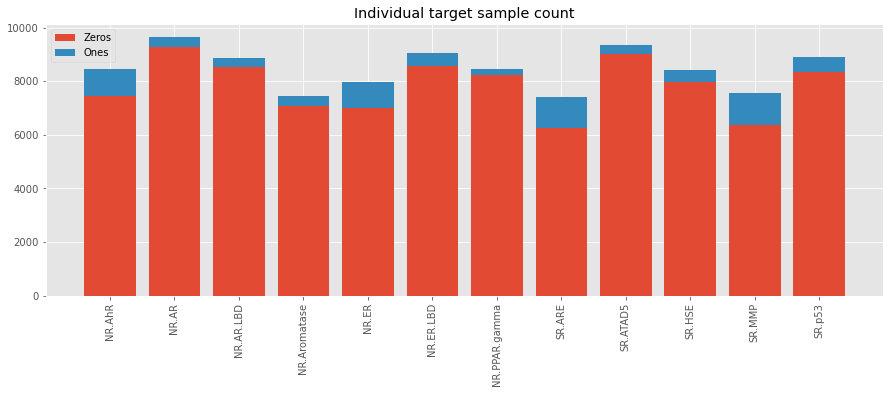

In [11]:
plt.figure(figsize=(15,5))
plt.bar(x=df_target.columns[1:].tolist(),height=np.array(each_target_zeros))
plt.bar(x=df_target.columns[1:].tolist(),height=np.array(each_target_ones),bottom=np.array(each_target_zeros))
plt.title("Individual target sample count")
plt.xticks(rotation='vertical')
plt.legend(["Zeros", "Ones"])
plt.show()

### Checking if there exist any row with all NaN value

In [12]:
# count = 0
# mol_idx = []
# for i in range(df_target.shape[0]):
#     temp = df_target.iloc[i,:]
#     if df_target.iloc[i,1:].isna().sum() == 12:
#         count += 1
#         mol_idx.append(i)

In [13]:
# count

No there is no such row with all NaN values.

### Checking if there exist any row with all zero values if we replace NaN with zero

In [14]:
df_target.fillna(0).head()

,Unnamed: 0,NR.AhR,NR.AR,NR.AR.LBD,NR.Aromatase,NR.ER,NR.ER.LBD,NR.PPAR.gamma,SR.ARE,SR.ATAD5,SR.HSE,SR.MMP,SR.p53
0,NCGC00178831-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NCGC00166114-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NCGC00263563-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NCGC00013058-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,NCGC00167516-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# count = 0
# mol_idx = []
# for i in range(df_target.shape[0]):
#     temp = df_target.iloc[i,:]
#     if df_target.iloc[i,1:].sum() == 0:
#         count += 1
#         mol_idx.append(i)

In [16]:
# count

We cannot assign 0 value as it will corrupt the original zero values, so lets assign 2 for all NaN values. This will make it a multiclass-multilabel (multi-task) problem type.  
- We can do the one-hot-encode of the target
- Or can use some other MultiTqaskLearning methods

In [17]:
df_target.iloc[:,1:].fillna(2).head()

,NR.AhR,NR.AR,NR.AR.LBD,NR.Aromatase,NR.ER,NR.ER.LBD,NR.PPAR.gamma,SR.ARE,SR.ATAD5,SR.HSE,SR.MMP,SR.p53
0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0
1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0
2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0
3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0
4,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


The labels semantic meaning:  
- 0 : non-toxic
- 1 : toxic
- 2 : don't care

In [18]:
df_target.fillna(2,inplace=True)

In [19]:
df_target.head()

,Unnamed: 0,NR.AhR,NR.AR,NR.AR.LBD,NR.Aromatase,NR.ER,NR.ER.LBD,NR.PPAR.gamma,SR.ARE,SR.ATAD5,SR.HSE,SR.MMP,SR.p53
0,NCGC00178831-03,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0
1,NCGC00166114-03,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0
2,NCGC00263563-01,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0
3,NCGC00013058-02,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0
4,NCGC00167516-01,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


### One hot encoding of target

In [20]:
target_cols = df_target.columns.tolist()[1:]
target_cols

['NR.AhR',
 'NR.AR',
 'NR.AR.LBD',
 'NR.Aromatase',
 'NR.ER',
 'NR.ER.LBD',
 'NR.PPAR.gamma',
 'SR.ARE',
 'SR.ATAD5',
 'SR.HSE',
 'SR.MMP',
 'SR.p53']

In [21]:
df_target_ohe = None
for col in target_cols:
    temp = pd.get_dummies(df_target[col],prefix='target_'+col)
    df_target_ohe = pd.concat([df_target_ohe,temp],axis=1)

In [22]:
df_target_ohe.head()

,target_NR.AhR_0.0,target_NR.AhR_1.0,target_NR.AhR_2.0,target_NR.AR_0.0,target_NR.AR_1.0,target_NR.AR_2.0,target_NR.AR.LBD_0.0,target_NR.AR.LBD_1.0,target_NR.AR.LBD_2.0,target_NR.Aromatase_0.0,...,target_SR.ATAD5_2.0,target_SR.HSE_0.0,target_SR.HSE_1.0,target_SR.HSE_2.0,target_SR.MMP_0.0,target_SR.MMP_1.0,target_SR.MMP_2.0,target_SR.p53_0.0,target_SR.p53_1.0,target_SR.p53_2.0
0,0,0,1,0,0,1,0,0,1,0,...,1,1,0,0,0,0,1,0,0,1
1,0,0,1,0,0,1,0,0,1,0,...,1,1,0,0,0,0,1,0,0,1
2,0,0,1,0,0,1,0,0,1,0,...,1,1,0,0,0,0,1,0,0,1
3,0,0,1,0,0,1,0,0,1,0,...,1,0,1,0,0,0,1,0,0,1
4,0,0,1,1,0,0,0,0,1,0,...,1,0,0,1,0,0,1,0,0,1


In [23]:
tcols = df_target_ohe.columns.tolist()

In [24]:
print(len(tcols[::3]))
print((tcols[::3]))
print(len(tcols[1::3]))
print((tcols[1::3]))
print(len(tcols[2::3]))
print((tcols[2::3]))

12
['target_NR.AhR_0.0', 'target_NR.AR_0.0', 'target_NR.AR.LBD_0.0', 'target_NR.Aromatase_0.0', 'target_NR.ER_0.0', 'target_NR.ER.LBD_0.0', 'target_NR.PPAR.gamma_0.0', 'target_SR.ARE_0.0', 'target_SR.ATAD5_0.0', 'target_SR.HSE_0.0', 'target_SR.MMP_0.0', 'target_SR.p53_0.0']
12
['target_NR.AhR_1.0', 'target_NR.AR_1.0', 'target_NR.AR.LBD_1.0', 'target_NR.Aromatase_1.0', 'target_NR.ER_1.0', 'target_NR.ER.LBD_1.0', 'target_NR.PPAR.gamma_1.0', 'target_SR.ARE_1.0', 'target_SR.ATAD5_1.0', 'target_SR.HSE_1.0', 'target_SR.MMP_1.0', 'target_SR.p53_1.0']
12
['target_NR.AhR_2.0', 'target_NR.AR_2.0', 'target_NR.AR.LBD_2.0', 'target_NR.Aromatase_2.0', 'target_NR.ER_2.0', 'target_NR.ER.LBD_2.0', 'target_NR.PPAR.gamma_2.0', 'target_SR.ARE_2.0', 'target_SR.ATAD5_2.0', 'target_SR.HSE_2.0', 'target_SR.MMP_2.0', 'target_SR.p53_2.0']


In [25]:
df_target_ohe = pd.concat([df_target['Unnamed: 0'],df_target_ohe],axis=1)
df_target_ohe = df_target_ohe.rename(columns={"Unnamed: 0": "id"})

In [26]:
df_target_ohe.head()

,id,target_NR.AhR_0.0,target_NR.AhR_1.0,target_NR.AhR_2.0,target_NR.AR_0.0,target_NR.AR_1.0,target_NR.AR_2.0,target_NR.AR.LBD_0.0,target_NR.AR.LBD_1.0,target_NR.AR.LBD_2.0,...,target_SR.ATAD5_2.0,target_SR.HSE_0.0,target_SR.HSE_1.0,target_SR.HSE_2.0,target_SR.MMP_0.0,target_SR.MMP_1.0,target_SR.MMP_2.0,target_SR.p53_0.0,target_SR.p53_1.0,target_SR.p53_2.0
0,NCGC00178831-03,0,0,1,0,0,1,0,0,1,...,1,1,0,0,0,0,1,0,0,1
1,NCGC00166114-03,0,0,1,0,0,1,0,0,1,...,1,1,0,0,0,0,1,0,0,1
2,NCGC00263563-01,0,0,1,0,0,1,0,0,1,...,1,1,0,0,0,0,1,0,0,1
3,NCGC00013058-02,0,0,1,0,0,1,0,0,1,...,1,0,1,0,0,0,1,0,0,1
4,NCGC00167516-01,0,0,1,1,0,0,0,0,1,...,1,0,0,1,0,0,1,0,0,1


In [27]:
df_target_ohe.to_csv('../input/processed/train_targets_ohe.csv',index=False)

### plotting target columns one counts

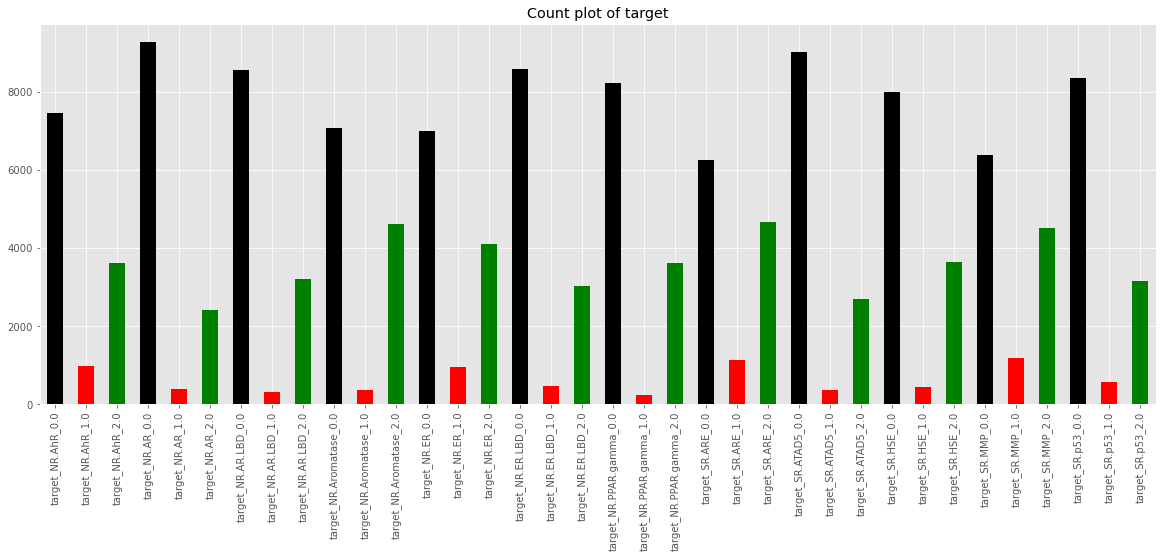

In [28]:
plt.figure(figsize=(20,7))
df_target_ohe.iloc[:,1:].sum().plot(kind='bar',color=['black', 'red', 'green'])
plt.title('Count plot of target')
plt.show()

### Feature analysis

In [29]:
df_feature.head()

,Unnamed: 0,AW,AWeight,Arto,BertzCT,Chi0,Chi1,Chi10,Chi2,Chi3,...,W3D,W3DH,WNSA1,WNSA2,WNSA3,WPSA1,WPSA2,WPSA3,grav,rygr
0,NCGC00178831-03,5.436720e+07,13.053,2.176,3.194,23.112,15.868,1.496,15.127,12.592,...,2687.469,9241.018,115.371,-915.496,-39.983,290.078,2301.941,59.492,88.147,3.708
1,NCGC00166114-03,1.268818e+07,22.123,2.065,3.137,21.033,13.718,1.937,13.187,11.951,...,2184.384,3234.199,194.740,-1029.609,-34.205,235.360,1244.323,82.906,134.852,4.131
2,NCGC00263563-01,3.076932e+06,13.085,2.154,3.207,46.896,29.958,3.806,30.105,25.569,...,13803.524,76582.899,238.004,-4358.946,-106.537,868.685,15909.444,135.335,216.852,5.075
3,NCGC00013058-02,7.168569e+07,12.832,2.029,3.380,51.086,32.045,1.806,29.090,21.603,...,13807.345,50498.175,226.312,-2785.555,-61.923,763.288,9394.859,125.509,238.265,4.640
4,NCGC00167516-01,7.989702e+06,12.936,2.124,3.573,70.295,46.402,3.604,42.132,32.570,...,43231.286,163659.229,850.869,-21136.699,-367.122,1798.703,44681.209,362.168,317.901,7.845


### Checking NaN values in the data

In [30]:
df_feature.isna().sum().sum()

0

No there exist no NaN values in the feature columns

### Checking for categorical and numerical columns

In [31]:
df_feature.columns.shape

(802,)

In [32]:
df_feature.dtypes.value_counts()

float64    761
int64       40
object       1
dtype: int64

In [33]:
df_feature.select_dtypes(include=np.float64).head()

,AW,AWeight,Arto,BertzCT,Chi0,Chi1,Chi10,Chi2,Chi3,Chi3c,...,W3D,W3DH,WNSA1,WNSA2,WNSA3,WPSA1,WPSA2,WPSA3,grav,rygr
0,5.436720e+07,13.053,2.176,3.194,23.112,15.868,1.496,15.127,12.592,2.619,...,2687.469,9241.018,115.371,-915.496,-39.983,290.078,2301.941,59.492,88.147,3.708
1,1.268818e+07,22.123,2.065,3.137,21.033,13.718,1.937,13.187,11.951,2.502,...,2184.384,3234.199,194.740,-1029.609,-34.205,235.360,1244.323,82.906,134.852,4.131
2,3.076932e+06,13.085,2.154,3.207,46.896,29.958,3.806,30.105,25.569,7.819,...,13803.524,76582.899,238.004,-4358.946,-106.537,868.685,15909.444,135.335,216.852,5.075
3,7.168569e+07,12.832,2.029,3.380,51.086,32.045,1.806,29.090,21.603,5.222,...,13807.345,50498.175,226.312,-2785.555,-61.923,763.288,9394.859,125.509,238.265,4.640
4,7.989702e+06,12.936,2.124,3.573,70.295,46.402,3.604,42.132,32.570,7.002,...,43231.286,163659.229,850.869,-21136.699,-367.122,1798.703,44681.209,362.168,317.901,7.845


In [34]:
float_cols = df_feature.select_dtypes(include=np.float64).columns.tolist()

In [35]:
df_feature.select_dtypes(include=np.int64).head()

,MRVSA7,PC1,PC2,PC3,PC4,PC5,PC6,Platt,Pol,Qindex,...,noxy,nphos,nring,nrot,nsb,nsulph,nta,ntb,slogPVSA8,RNCS
0,0,37,54,72,98,136,146,108,54,26,...,0,0,6,0,5,0,59,0,0,0
1,0,32,49,71,98,140,181,98,59,22,...,5,0,4,2,9,5,37,0,0,0
2,0,70,111,153,210,276,338,222,126,54,...,17,0,7,13,69,17,148,0,0,0
3,0,69,92,108,120,152,170,184,90,28,...,12,0,6,6,31,12,122,0,0,0
4,0,103,141,176,223,265,292,282,142,53,...,14,0,8,32,60,14,184,0,0,0


In [36]:
int_cols = df_feature.select_dtypes(include=np.int64).columns.tolist()

In [37]:
# for col in int_cols:
#     fig, ax = plt.subplots(figsize=(20,5))
#     sns_plot = sns.countplot(x = df_feature[col],ax=ax)
#     sns_plot.figure.savefig(f"../images/int_{col}.png")
#     plt.show()

### Floating columns analysis

In [38]:
df_float = df_feature[float_cols]

In [39]:
df_float.head()

,AW,AWeight,Arto,BertzCT,Chi0,Chi1,Chi10,Chi2,Chi3,Chi3c,...,W3D,W3DH,WNSA1,WNSA2,WNSA3,WPSA1,WPSA2,WPSA3,grav,rygr
0,5.436720e+07,13.053,2.176,3.194,23.112,15.868,1.496,15.127,12.592,2.619,...,2687.469,9241.018,115.371,-915.496,-39.983,290.078,2301.941,59.492,88.147,3.708
1,1.268818e+07,22.123,2.065,3.137,21.033,13.718,1.937,13.187,11.951,2.502,...,2184.384,3234.199,194.740,-1029.609,-34.205,235.360,1244.323,82.906,134.852,4.131
2,3.076932e+06,13.085,2.154,3.207,46.896,29.958,3.806,30.105,25.569,7.819,...,13803.524,76582.899,238.004,-4358.946,-106.537,868.685,15909.444,135.335,216.852,5.075
3,7.168569e+07,12.832,2.029,3.380,51.086,32.045,1.806,29.090,21.603,5.222,...,13807.345,50498.175,226.312,-2785.555,-61.923,763.288,9394.859,125.509,238.265,4.640
4,7.989702e+06,12.936,2.124,3.573,70.295,46.402,3.604,42.132,32.570,7.002,...,43231.286,163659.229,850.869,-21136.699,-367.122,1798.703,44681.209,362.168,317.901,7.845


In [40]:
# for col in random.sample(float_cols,40):
#     fig, ax = plt.subplots(figsize=(20,5))
#     sns_plot = sns.countplot(x = df_feature[col],ax=ax)
#     sns_plot.figure.savefig(f"../images/float_{col}.png")
# #     plt.show()

In [41]:
# from pandas_profiling import ProfileReport

In [42]:
# profile = ProfileReport(df, minimal=True)
# profile.to_file(output_file="output.html")

#### PCA

In [43]:
leftdf = pd.DataFrame({'A':np.random.rand(10),'B':np.random.randn(10)})
rightdf = pd.DataFrame({'A':np.random.rand(10),'B':np.random.randn(10)}).add_suffix('_pred')

In [44]:
pd.concat([leftdf,rightdf],axis=1,)

,A,B,A_pred,B_pred
0,0.975702,-0.015106,0.020758,-0.782326
1,0.071587,-0.632158,0.016032,-0.342901
2,0.839751,0.442402,0.047402,0.524845
3,0.191907,-0.328060,0.506967,-0.832665
4,0.225710,2.531908,0.494152,-0.295427
5,0.079223,-1.898692,0.718431,0.610810
6,0.987249,1.946855,0.714208,-0.110893
7,0.007146,0.759871,0.149474,-1.861154
8,0.767556,-1.122092,0.782167,-1.067904
9,0.404478,-0.121228,0.291413,0.129777


### Saving feature columns

In [45]:
df_feature.rename(columns={"Unnamed: 0":"id"},inplace=True)
df_feature.to_csv('../input/processed/train_features.csv',index=False)